# Classification Pipeline

In [ ]:
%reload_ext autoreload
%autoreload 3

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import SVC, LinearSVC
from src.sugnet.pipeline import FeatureExtractor

In [2]:
CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
CHANCE_CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
n_permutations = 40
output_path = Path('data/classification_output')

In [3]:
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')

# DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [ ]:
# 2. PIPELINE
pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', 'passthrough'),
    ('clf', LinearSVC(max_iter=1000000, dual=True, class_weight='balanced')),
])

# scores = cross_val_score(pipe, X, y, groups=groups, cv=CV, scoring='accuracy')
# scores.mean(), scores.std(), st.bootstrap(scores.reshape(1, -1), np.mean)

In [5]:
# 3. Grid Search
grid_params = [{
    'extract__kind': ['correlation source', 'power source', 'power sensor',
                      'plv source', 'correlation sensor', 'plv sensor'],
    'extract__frequency_band': ['delta', 'theta', 'alpha', 'beta', 'gamma'],
    'select': [SelectFromModel(SVC(kernel="linear")), 'passthrough'],
    'clf__C': [0.1, 0.5, 1, 5, 10, 50, 100],
}]

grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X, y, groups=groups)

Fitting 200 folds for each of 350 candidates, totalling 70000 fits


GridSearchCV(cv=GroupShuffleSplit(n_splits=200, random_state=None, test_size=0.2,
         train_size=None),
             estimator=Pipeline(steps=[('extract', FeatureExtractor()),
                                       ('zerovar', VarianceThreshold()),
                                       ('scale', StandardScaler()),
                                       ('select', 'passthrough'),
                                       ('clf',
                                        LinearSVC(class_weight='balanced',
                                                  max_iter=1000000))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.1, 0.5, 1, 5, 10, 50, 100],
                          'extract__frequency_band': ['delta', 'theta', 'alpha',
                                                      'beta', 'gamma'],
                          'extract__kind': ['correlation source',
                                            'power source', 'power sensor',
                                

## Grid Results

In [4]:
# 4. Prepare grid results to plot
# grid_results = pd.DataFrame(grid.cv_results_)
grid_results = pd.read_csv('data/classification_results/grid_results.csv')  # load from file

grid_results['label'] = grid_results['param_extract__kind'] + ' (' + grid_results['param_extract__frequency_band'] + ')'

# Sift out the best params (C and feature selections) for each model
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]
grid_results.drop_duplicates(subset='label', inplace=True)

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')

def fit_chance(model_name=None):
    """Utility function to simulate emperical chance level."""
    
    chance_model = DummyClassifier(strategy='most_frequent')
    chance_scores = cross_val_score(chance_model, X, y, groups=groups, cv=CHANCE_CV, scoring='accuracy', n_jobs=-1)
    return chance_scores

chance_scores = {}
for model_name in grid_results['label'].unique():
    model_chance_scores = fit_chance(model_name)
    chance_scores[model_name] = model_chance_scores.tolist()
    
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

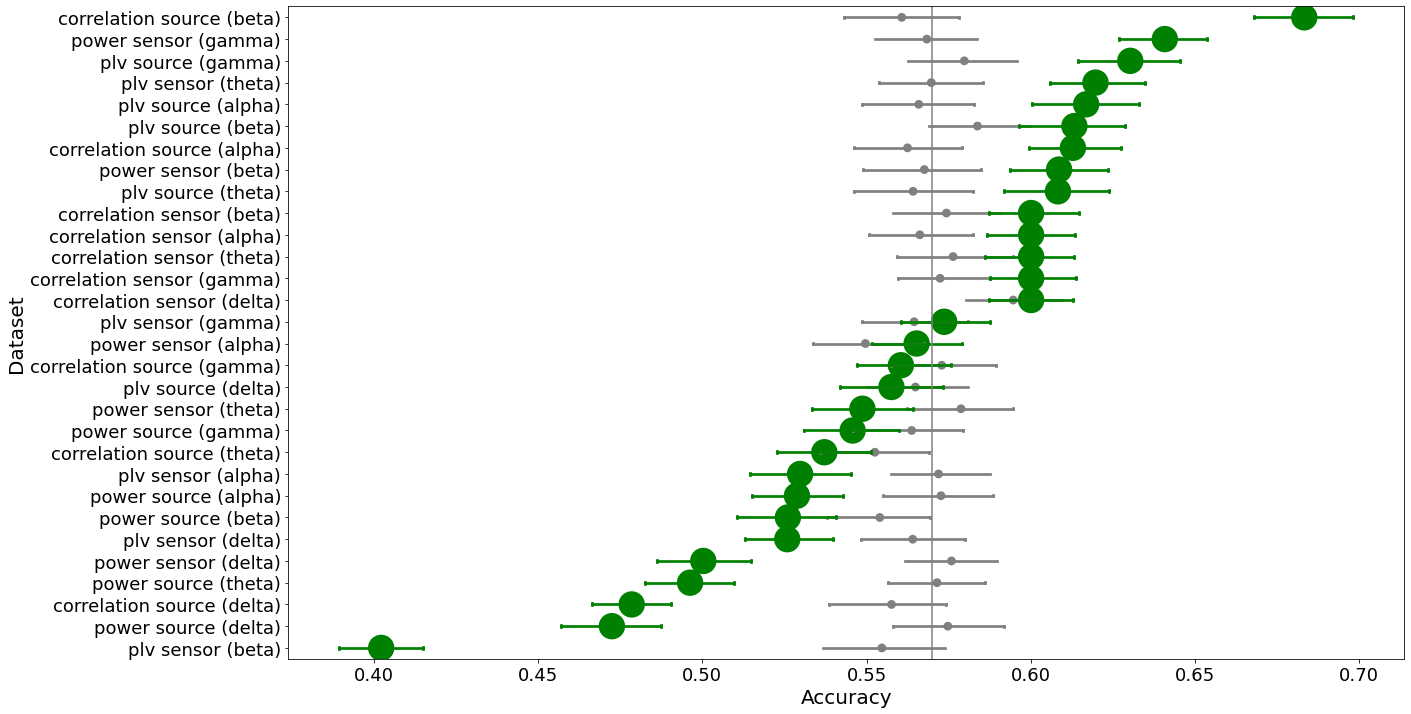

In [6]:
# plot model performance against chance level
from cProfile import label
from ctypes import sizeof


_, ax = plt.subplots(1, 1, figsize=(20, 12))
order = grid_results.groupby('label')['test_score'].mean().sort_values(ascending=False).index.values

# plot chance
sns.pointplot(data=chance_scores, x='test_score', y='label', order=order, orient='h',
              color='gray', scale=1, capsize=0.03, join=False, label='Chance',
              ax=ax, errorbar=('ci', 99)
              )

# plot observed
sns.pointplot(data=grid_results, x='test_score', y='label', order=order, orient='h',
              color='green', scale=3, capsize=0.09, join=False, label='Accuracy',
              ax=ax, errorbar=('ci', 99)
              )

# Add horizontal line indicating the baseline value
plt.axvline(0.57, color='grey', linestyle='-')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Accuracy', fontsize=20)
plt.ylabel('Dataset', fontsize=20)

# plt.legend(loc="upper left")

plt.show()

## Model-agnosis explanation

In [45]:
from sklearn.inspection import permutation_importance
from collections import defaultdict
import shap
import ast
from tqdm.auto import tqdm

CV_EXPLAIN = StratifiedGroupKFold(n_splits=5, shuffle=True)
n_iterations = 40

In [51]:
model_names = grid_results.groupby('label')['mean_test_score'].mean().sort_values(ascending=False).index.values
importances = {}
shap_values = {}
y_tests = {}
y_preds = {}
test_indices = {}


for model_name in model_names[:3]:
    params = grid_results.query('label == @model_name')['params'].iloc[0]
    params = ast.literal_eval(params)
    pipe.set_params(**params)

    X_t = pipe[:-2].fit_transform(X, y)
    feature_names = pipe[:-2].get_feature_names_out()
    model_importances = []
    model_shapes = []
    _test_indices = []
    y_test_cv = []
    y_pred_cv = []

    for iter in tqdm(range(n_iterations), desc=model_name):
        for train, test in CV_EXPLAIN.split(X, y, groups=groups):

            model = pipe[-2:].fit(X_t[train], y[train])
            y_pred = model.predict(X_t[test])
            
            _test_indices.extend(test)
            y_test_cv.append(y[test])
            y_pred_cv.append(y_pred)
            
            explainer = shap.Explainer(model.predict, X_t[train], feature_names=feature_names)
            cv_shap_values = explainer(X_t[test], max_evals=len(feature_names)*2+1)
            model_shapes.append(cv_shap_values)
            

            perm_scores = permutation_importance(model, X_t[test], y[test], n_repeats=30, n_jobs=-1)
            cv_importances = pd.DataFrame(perm_scores['importances'].T, columns=feature_names)
            model_importances.append(cv_importances)
    
    importances[model_name] = pd.concat(model_importances)
    
    y_tests[model_name] = np.hstack(y_test_cv)
    y_preds[model_name] = np.hstack(y_pred_cv)
    test_indices[model_name] = np.array(_test_indices)
    
    shap_values[model_name] = shap.Explanation(
        values=np.vstack([sh.values for sh in model_shapes]),
        base_values=np.hstack([sh.base_values for sh in model_shapes]),
        data=np.vstack([sh.data for sh in model_shapes]),
        feature_names=feature_names,
        output_indexes=y_pred,
        output_names=['low', 'high']
    )

correlation source (beta):   0%|          | 0/40 [00:00<?, ?it/s]

power sensor (gamma):   0%|          | 0/40 [00:00<?, ?it/s]

plv source (gamma):   0%|          | 0/40 [00:00<?, ?it/s]

In [52]:
# save importances and shap values as pickle files
import pickle
with open('data/classification_results/importances_stratifiedCV_shuffled.pkl', 'wb') as f:
    pickle.dump(importances, f)
    
y_preds_ = {f'y_pred-{k}':v for k,v in y_preds.items()}
y_tests_ = {f'y_test-{k}':v for k,v in y_tests.items()}
test_indices_ = {f'test_indices-{k}':v for k,v in test_indices.items()}

new_dict = shap_values | y_preds_ | y_tests_ | test_indices_
with open('data/classification_results/shap_values_stratifiedCV_shuffled.pkl', 'wb') as f:
    pickle.dump(new_dict, f)